In [1]:
import sys
sys.path.insert(0, '..')

import PipelineTS
PipelineTS.__version__

'0.3.10'

# Using Optuna

In [2]:
import pandas as pd

# define optimization target
from sklearn.metrics import mean_absolute_error
evaluation_metric = mean_absolute_error

# preprocess data
from PipelineTS.dataset import LoadMessagesSentDataSets
init_data = LoadMessagesSentDataSets()
time_col = init_data.time_col
target_col = init_data.target_col

init_data[time_col] = pd.to_datetime(init_data[time_col])

# dividing the training set and the validation set
valid_data = init_data[[time_col, target_col]].iloc[-30:, :]
data = init_data[[time_col, target_col]].iloc[:-30, :]

# set the computing device, which will specify the computing device for the neural network model
# default to 'auto'
accelerator = 'auto'  

# set the step size for prediction
n = 30

from PipelineTS.pipeline import ModelPipeline

In [5]:
import optuna
from PipelineTS.nn_model import StackingRNNModel

# The objective function is referenced from https://optuna.org/#code_ScikitLearn
# 1. Define an objective function to be maximized.
def objective(trial):

    # 2. Suggest values for the hyperparameters using a trial object.
    lags = trial.suggest_int('lags', 8, 60, step=2)
    # kernel_size = trial.suggest_int('kernel_size', 2, 5, log=True)
    # dropout = trial.suggest_float('dropout', 0.1, 0.5, log=True)

    pipeline = ModelPipeline(
        time_col=time_col,
        target_col=target_col,
        lags=lags,  
        random_state=42,
        include_models=StackingRNNModel,
        # Specify the performance evaluation criteria when training the model with the pipeline. The default is mean absolute error.
        metric=evaluation_metric,
        # Is it better to have a lower performance evaluation standard
        metric_less_is_better=True,
        # set the computing device, which will specify the computing device for the neural network model
        accelerator=accelerator,
        
        # False for MinMaxScaler, True for QuantileTransformer, None means no data be scaled
        scaler=False,

        # Here's an example where you can specify model hyperparameters like this
        # TCNModel__kernel_size=kernel_size,
        # TCNModel__dropout=dropout
    )

    pipeline.fit(data, valid_data=valid_data)

    return evaluation_metric(pipeline.predict(n)[target_col].values, valid_data[target_col].values)

# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

[I 2023-11-20 15:55:08,359] A new study created in memory with name: no-name-e576220a-9e24-436a-8806-bdf9e211e215
MPS  available: True   | MPS  use: True
CUDA available: False  | CUDA use: False
TPU  available: False  | TPU  use: False
CPU  available: True   | CPU  use: False

15:55:08 2023-11-20 - PipelineTS - There are a total of 1 models to be trained.
15:55:08 2023-11-20 - PipelineTS - [model 0] fitting and evaluating StackingRNNModel...
[I 2023-11-20 15:55:39,360] Trial 0 finished with value: 13793.19880609562 and parameters: {'lags': 26}. Best is trial 0 with value: 13793.19880609562.
MPS  available: True   | MPS  use: True
CUDA available: False  | CUDA use: False
TPU  available: False  | TPU  use: False
CPU  available: True   | CPU  use: False

15:55:39 2023-11-20 - PipelineTS - There are a total of 1 models to be trained.
15:55:39 2023-11-20 - PipelineTS - [model 0] fitting and evaluating StackingRNNModel...
[I 2023-11-20 15:56:09,918] Trial 1 finished with value: 7217.62166082

In [6]:
study.best_trial.params

{'lags': 56}

MPS  available: True   | MPS  use: True
CUDA available: False  | CUDA use: False
TPU  available: False  | TPU  use: False
CPU  available: True   | CPU  use: False

16:06:59 2023-11-20 - PipelineTS - There are a total of 1 models to be trained.
16:06:59 2023-11-20 - PipelineTS - [model 0] fitting and evaluating StackingRNNModel...


mae: 3483.5307484482723


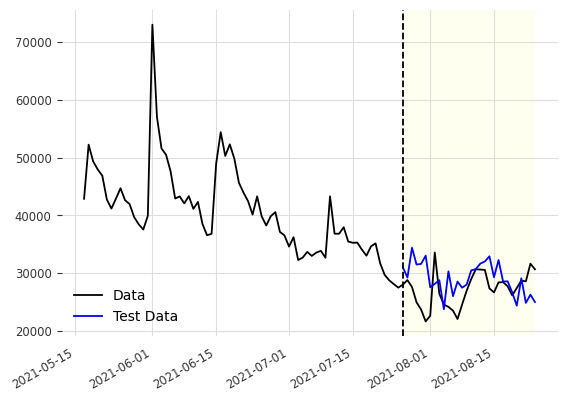

In [7]:
from PipelineTS.nn_model import StackingRNNModel

pipeline = ModelPipeline(
    time_col=time_col,
    target_col=target_col,
    lags=56,  
    random_state=42,
    include_models=StackingRNNModel,
    # Specify the performance evaluation criteria when training the model with the pipeline. The default is mean absolute error.
    metric=evaluation_metric,
    # Is it better to have a lower performance evaluation standard
    metric_less_is_better=True,
    # set the computing device, which will specify the computing device for the neural network model
    accelerator=accelerator,
    
    # False for MinMaxScaler, True for QuantileTransformer, None means no data be scaled
    scaler=False,

    # TCNModel__kernel_size=5,
    # TCNModel__dropout=0.3075180431196903
)

pipeline.fit(data)


prediction = pipeline.predict(n)  

print('mae:', evaluation_metric(prediction[target_col].values, valid_data[target_col].values))

from PipelineTS.plot import plot_data_period

plot_data_period(init_data.iloc[-100:, :], prediction, 
                 time_col=time_col, target_col=target_col)